## ***Jupyter Notebook to accompany the paper:***
    
# ***the new APWPs***

### ***by L. C. Gallo$^1$*** *(len.gallo@gmail.com)* *** and list of co-authors $^1$***

# Exploration and Preprocessing of VGP database

This notebook preprocesses site level data from the VGP database compilation, checks for missing data, compares reported and calculated pole positions, conducts associated statistical tests, and makes visualizations of data at the study level.

## Import scientific Python libraries

Import scipy python libraries as well as functions written for the project within vgptools.

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from scipy import optimize
import seaborn as sns

from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, 
                               cartesian2spherical, GCD_cartesian, 
                               print_pole_statistics, test_fishqq, 
                               statistical_tests, summary_figure,
                               invert_polarity, Plot_VgpsAndSites)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

## Gather study files

We retrieve all the spreadsheet files corresponding to different studies for which site level data are compiled. 

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'
files_names = get_files_in_directory(data_path_VGP)

xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')] 
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})
df_files[['name_xlsx']]

name_xlsx
0                Tequila_volcanic_field
1                  Coso_Range_volcanics
2             Eastern_Alkaline_Province
3                      SW_USA_composite
4                  N_Montana_intrusions
5         Long_Valley_Caldera_volcanics
6        Robinson_Antincline_intrusions
7       Central_Mexico_Plio-Pleistocene
8           Rattlesnake_Hills_volcanics
9                   Ramsay_Island_lavas
10                 Sierra_de_Las_Cruces
11                    Snake_River_Plain
12                     Sonoma_volcanics
13                Mistastin_Lake_impact
14              Bighorn_Basin_sediments
15                   Absaroka_volcanics
16                         Eastern_TMVB
17                          Bishop_tuff
18                 Western_Central_TMVB
19                      Dinan_Bay_lavas
20             Valles_Caldera_volcanics
21           Bitterroot_Dome_intrusions
22          Stoddard_Mountain_laccolith
23  Michoacan_Guanajuato_volcanic_field
24            Clear_Lake_volcanic_field
25             San_Luis_Hills_volcanics
26              Beaver_River_intrusions
27              Mariscal_Mtn_intrusions
28             Mogollon-Datil_volcanics
29                  Monterey_intrusions
30                 Latir_volcanic_field

## Single study inspection

In order to understand what is going on in one single site, we can conduct statistical tests and visualize the data. 

In [8]:
file_idx = 0

#### Separate the *.xlsx file into two different DFs, `df_vgps` and `df_poles`. 

*Note: the the number of lines to be skipped is hardcoded.*

In [9]:
def split_datasheet(df_files, file_idx):
    """
    Reads in datasheets and splits them into pole and vgp collections to be filtered, collated and compiled.
    Input: standard vgp datasheet (as described in datasheet template)
    Output: separate dataframes comprised of the study-level poles and site-level vgps extracted from the datasheet
    """
    df = pd.read_excel(df_files['path'][file_idx]) #, skip_blank_lines=True
    df_poles = pd.read_excel(df_files['path'][file_idx], 
                             skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                             nrows  = df[df.isnull().all(1)].index[1] -3)

    df_vgps = pd.read_excel(df_files['path'][file_idx], 
                            skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

    #cast columns
    df_vgps = df_vgps.astype({'in_study_pole': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "VGP_lat":float, "VGP_lon":float
                             })
    df_poles = df_poles.astype({'N': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "Plat":float, "Plon":float})
    return (df_poles, df_vgps)

df_poles, df_vgps = split_datasheet(df_files, file_idx)

## We then proceed to populate the VGP DataFrame (`df_vgps`) following different criteria
 1. In a previous step, we have calculated the site coordinates of all studies in which these coordinates were not reported, but the Dec/Inc and Plat/Plon were. 
 2. We recalculate the VGP longitudes and latitudes based on the site mean declination/inclination and site location longitude/latitude.

In [10]:
#First we calculate for the entire dataframe the vgps if there is dec/inc and slat/slon values
def recalc_vgps(df_vgps):
    df_vgps['VGP_lon_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1)
    df_vgps['VGP_lat_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    return df_vgps

df_vgps = recalc_vgps(df_vgps)

## Check polarity of VGPs against directions
 3. Some sites report the backward VGP (so that the VGPs are in the same hemisphere/closer to the principal component). We proceed to check polarity of VGPs against directions. To do that, we recalculate the vgps from the original Dec/Inc.
 
4. Check distance (`df_vgps['GCD_vgps']`) between the reported VGPs and the recalculated from the directions.

In this step we fill the column `df_vgps['coherent_vgps']` with the following tags: 
- 'spurious' if inconsistent combination of site coordinates + dec/inc + vgp data (+- 4 degrees away from the reported or its backward)
- 'coherent' if correct
- 'inverted' if inverted

In [11]:
def check_coherence_vgps(df_vgps):

    df_vgps['GCD_vgps'] = df_vgps.apply(lambda row: GCD_cartesian(spherical2cartesian([np.radians(row.VGP_lat), np.radians(row.VGP_lon)]), spherical2cartesian([np.radians(row.VGP_lat_recalc), np.radians(row.VGP_lon_recalc)])), axis=1)

    # False if Spurious, True if correct, nan if inverted
    df_vgps['coherent_vgps'] = df_vgps.apply(lambda row: 'spurious' if (row.GCD_vgps > np.radians(4) and row.GCD_vgps < np.radians(176)) else ('coherent' if row.GCD_vgps < np.radians(4) else 'inverted' if row.GCD_vgps > np.radians(176) else np.nan ), axis =1) #True if it is ok, nan
    
    return df_vgps
df_vgps = check_coherence_vgps(df_vgps)

### Catch some exceptions:
 - Missing slat/slon and/or dec/in where no vgp is reported
 - Missing dec/inc and/or vgp where no site coordinates are reported; cannot calculate site locations.
 - Inconsistent combination of site coordinates + dec/inc + vgp
 - Recalculated VGP was inverted. 

In [12]:
def verbose(df_vgps):
    
    if not df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna())].empty:
        print (f" => Missing slat/slon from sites ('name'): {df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna())].empty:
        print (f" => Missing dec/inc from sites ('name'): {df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
        print (f" => Missing reported VGPs from sites ('name'): {df_vgps[(df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() & df_vgps['slat'].isna())].empty:    
        print (f" => Missing slat/slon and/or dec/inc from sites ('name'): {df_vgps[(df_vgps['dec'].isna() & df_vgps['slat'].isna())].name.tolist()} where no vgp is reported; cannot calculate vgp")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'spurious'].empty:
        print (f" => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) {df_vgps[df_vgps['coherent_vgps'] == 'spurious'].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'inverted'].empty:
        print (f" => inverted vgp from sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'inverted'].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'coherent'].empty:
        print (f" => Coherent dec/inc in sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'coherent'].name.tolist()}")
        print (f"")
        
verbose(df_vgps)

 => Coherent dec/inc in sites ('name'): ['TL1', 'TL5', 'TM3', 'TM2', 'TM1', 'TM6', 'TM11', 'TM10', 'TM9', 'TL2', 'TL9', 'TM5', 'TM8', 'TL3', 'TL12', 'TL4', 'TL10', 'TL7', 'TL11', 'TM4', 'TM7']



### Summarize site level data

For each reported pole from the selected manuscript, we iterate through the constituent site-level data and: 
1) cast all vgps into a common polarity and re-compute the Fisher mean paleomagnetic pole
2) plot the site locations, vgps, and the results of reversal and Fisher distribution tests

==>Analyzing pole 1 (Tequila_volcanic_field).



N  Plat  Plon  A95
Reported mean pole                                  17  85.8  84.3  6.9
Mean pole (calculated from VGPs)                    17  85.8  84.4  6.9
Mean pole (calculated from transformed directions)  17  85.4  83.9  6.9

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


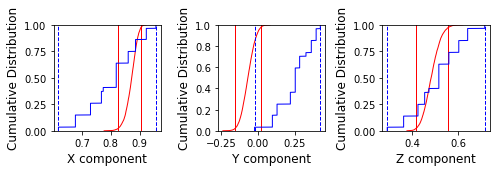

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           4.3
Critical value of V:  11.2
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 18.8
Critical angle for M&M1990:   30.7
The McFadden and McElhinny (1990) classification for
this test is: 'INDETERMINATE;

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Ambiguous: weak support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


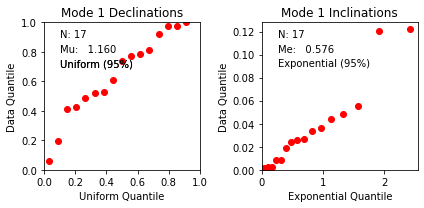

Consistent with Fisher distribution


result
Bootstrap reversal test                                                                          Pass
Parametric reversal test  Pass (angle 18.8º below 30.7º critical angle); indeterminate classification
Bayesian reversal test                                                        Ambiguous: weak support
Fisher Q-Q test                                                   Consistent with Fisher distribution

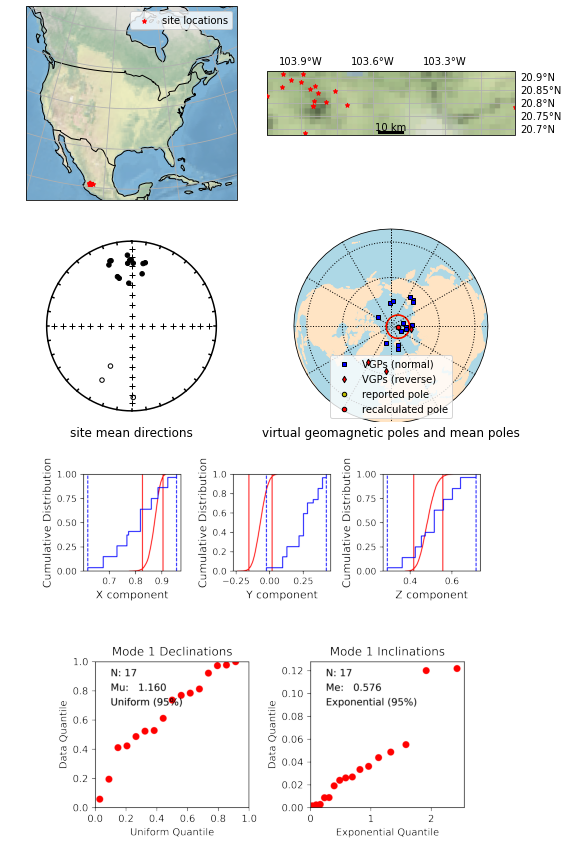

In [14]:
studies, pps, misfit, misfit_type = [], [], [], []

def process_study(df_vgps,file_idx):
    for pole, df_pole in df_vgps.groupby('in_study_pole'):
        
        df_pole.to_csv('testdf.csv')
        # value represent the index and i represent the DF grouped by the variable of interest  
        if pole != 0: #does not consider vgps discarded by authors

            print(f"==>Analyzing pole {pole} ({df_files.name_xlsx[file_idx]}).")
            print('')

            directions_block = ipmag.make_di_block(df_pole['dec'].tolist(), 
                                                   df_pole['inc'].tolist(),
                                                   unit_vector=False)
            di_mode1, di_mode2 = pmag.separate_directions(di_block=directions_block)

            vgp_recalc_block = ipmag.make_di_block(df_pole['VGP_lon_recalc'].tolist(), 
                                                   df_pole['VGP_lat_recalc'].tolist(),
                                                   unit_vector=False)
            #split recalculated vgp population into polarities             
            vgp_mode1, vgp_mode2 = pmag.separate_directions(di_block=vgp_recalc_block)
            merged_vgps = invert_polarity(vgp_mode1, vgp_mode2)
            vgp_mean_recomputed = ipmag.fisher_mean(di_block = merged_vgps)

            # calculate the Fisher mean of reported VGPs
            df_pole['VGP_lat'] = np.where(df_pole['VGP_lat'].isna(), df_pole['VGP_lat_recalc'], df_pole['VGP_lat'])
            df_pole['VGP_lon'] = np.where(df_pole['VGP_lon'].isna(), df_pole['VGP_lon_recalc'], df_pole['VGP_lon'])
            df_pole['vgp_lat_NH'] = np.where(df_pole['VGP_lat'] < 0, -df_pole['VGP_lat'], df_pole['VGP_lat'])
            df_pole['vgp_lon_NH'] = np.where(df_pole['VGP_lat'] < 0,(df_pole['VGP_lon'] - 180.) % 360., df_pole['VGP_lon'])             
            vgp_mean = ipmag.fisher_mean(dec = df_pole['vgp_lon_NH'].tolist(), inc = df_pole['vgp_lat_NH'].tolist())

            #reported pole
            reported_pole = df_poles[df_poles['pole'] == pole]

            study_number = file_idx
            study_folder = './study_summaries' + '/' +  str(study_number)
            if not os.path.exists(study_folder):
                os.mkdir(study_folder)

            pole_number = pole
            pole_folder = study_folder + '/' + str(pole_number)
            if not os.path.exists(pole_folder):
                os.mkdir(pole_folder)

            pole_summary = print_pole_statistics(reported_pole, 
                                                 vgp_mean, 
                                                 vgp_mean_recomputed)

            with open(pole_folder + '/pole_summary.tex','w') as tf:
                tf.write(pole_summary.to_latex())

            stat_test_results = statistical_tests(di_mode1, di_mode2, merged_vgps, 
                                                  study_number=file_idx, 
                                                  pole_number=pole, 
                                                  save_folder=pole_folder)

            with open(pole_folder + '/stat_test.tex','w') as tf:
                tf.write(stat_test_results.to_latex())

            summary_figure(df_pole, vgp_mode1, vgp_mode2, 
                           reported_pole, vgp_mean, pole_folder)

            study_name = str(df_files.name_xlsx[file_idx])
            study_name = study_name.replace('_', ' ')
            pole_local_folder = './' + str(study_number) + '/' + str(pole_number)
            tex_file = open('./study_summaries/SI_study_summary.tex', 'a')
            tex_file.write('\n')

            if pole_number == 1:
                tex_file.write('\section{' + study_name + '}')
                tex_file.write('\n')
                tex_file.write('\subsection{Pole ' + str(pole) + '}')
            if pole_number > 1:
                tex_file.write('\subsection{Pole ' + str(pole) + '}')
            tex_file.write('\n')
            tex_file.write('\input{' + pole_local_folder + '/pole_summary.tex' + '}')
            tex_file.write('\n')
            tex_file.write('\input{' + pole_local_folder + '/stat_test.tex' + '}')
            tex_file.write('\n')
            tex_file.write('\\begin{figure}[H]')
            tex_file.write('\n')
            tex_file.write('\centering')
            tex_file.write('\n')
            tex_file.write('\includegraphics[width=5 in]{' + pole_local_folder + '/pole_summary.png}')
            tex_file.write('\n')
            tex_file.write('\caption{Summary of data from locality ' + str(file_idx) + ' (' + study_name + ') pole ' + str(pole) + ' (' + reported_pole['pmag_ref'].tolist()[0] + ').}')
            tex_file.write('\n')
            tex_file.write('\end{figure}')
            tex_file.write('\n')
            tex_file.close()
            
            try:
               vgp_mean['dec'].tolist()
            except KeyError:
               vgp_mean = None

            if vgp_mean is not None:
                studies.append(df_files.name_xlsx[file_idx])
                pps.append(pole)
                misfit.append(pmag.angle([vgp_mean['dec'], vgp_mean['inc']], 
                                       [reported_pole.iloc[0]['Plon'], reported_pole.iloc[0]['Plat']])[0])
                misfit_type.append('reported')

                studies.append(df_files.name_xlsx[file_idx])
                pps.append(pole)                
                misfit.append(pmag.angle([vgp_mean_recomputed['dec'], vgp_mean_recomputed['inc']], 
                                       [reported_pole.iloc[0]['Plon'], reported_pole.iloc[0]['Plat']])[0])
                misfit_type.append('recalculated')
                
            print('')
            plt.pause(10)
            
process_study(df_vgps,file_idx)

# Iterate through all the files to generate summary plots and catch exceptions:


========================= NEW POLE : Tequila_volcanic_field (0) =======================
 => Coherent dec/inc in sites ('name'): ['TL1', 'TL5', 'TM3', 'TM2', 'TM1', 'TM6', 'TM11', 'TM10', 'TM9', 'TL2', 'TL9', 'TM5', 'TM8', 'TL3', 'TL12', 'TL4', 'TL10', 'TL7', 'TL11', 'TM4', 'TM7']

==>Analyzing pole 1 (Tequila_volcanic_field).



N  Plat  Plon  A95
Reported mean pole                                  17  85.8  84.3  6.9
Mean pole (calculated from VGPs)                    17  85.8  84.4  6.9
Mean pole (calculated from transformed directions)  17  85.4  83.9  6.9

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


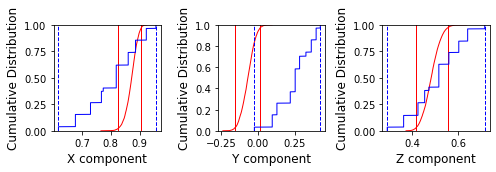

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           4.3
Critical value of V:  11.1
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 18.8
Critical angle for M&M1990:   30.5
The McFadden and McElhinny (1990) classification for
this test is: 'INDETERMINATE;

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Ambiguous: weak support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


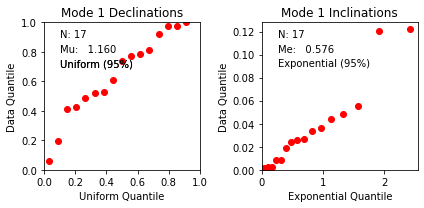

Consistent with Fisher distribution


result
Bootstrap reversal test                                                                          Pass
Parametric reversal test  Pass (angle 18.8º below 30.5º critical angle); indeterminate classification
Bayesian reversal test                                                        Ambiguous: weak support
Fisher Q-Q test                                                   Consistent with Fisher distribution

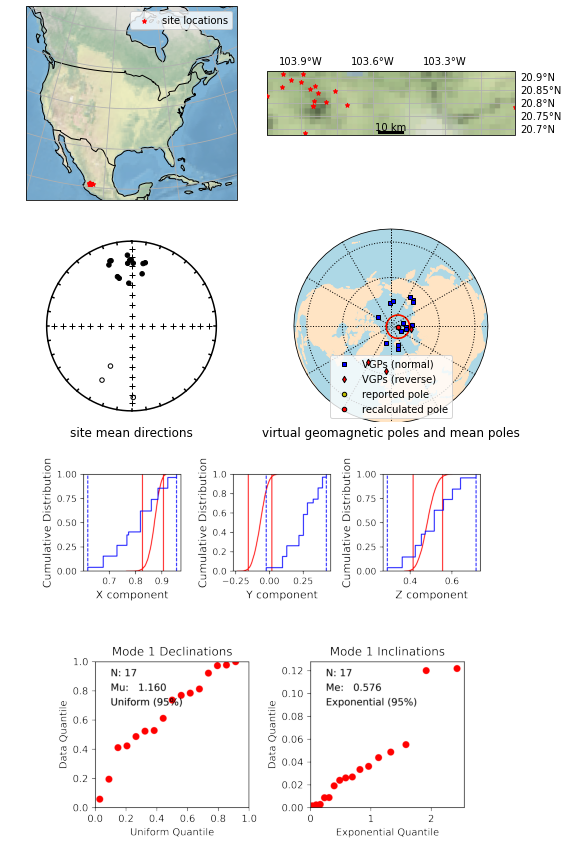


========================= NEW POLE : Coso_Range_volcanics (1) =======================
 => Coherent dec/inc in sites ('name'): [58.0, 35.0, 32.0, 33.0]

==>Analyzing pole 1 (Coso_Range_volcanics).



N  Plat  Plon   A95
Reported mean pole                                  2   NaN   NaN   NaN
Mean pole (calculated from VGPs)                    2  73.8  69.3  66.8
Mean pole (calculated from transformed directions)  2  73.8  69.3  66.8


Not enough sites from one (or both) polarity populations to conduct Bootstrap and parametric reversal tests

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------
Not enough sites to conduct Q-Q test


result
Bootstrap reversal test            Too few sites for test
Parametric reversal test           Too few sites for test
Bayesian reversal test    Different means: strong support
Fisher Q-Q test                             Too few sites

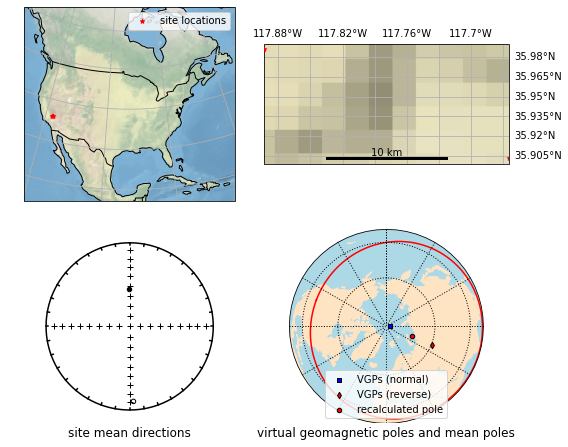


========================= NEW POLE : Eastern_Alkaline_Province (2) =======================
 => Missing reported VGPs from sites ('name'): ['VE17']

 => Coherent dec/inc in sites ('name'): ['VE18', 'VE19', 'VE10', 'VE13', 'VE12', 'VE09', 'VE11', 'VE14', 'VE16', 'VE05', 'VE03', 'VE02', 'VE04', 'VE07', 'VE01', 'VE06', 'VE15', 'VE08']

==>Analyzing pole 1 (Eastern_Alkaline_Province).



N  Plat  Plon  A95
Reported mean pole                                  17   NaN   NaN  NaN
Mean pole (calculated from VGPs)                    17  88.3  93.4  5.5
Mean pole (calculated from transformed directions)  17  88.3  87.7  5.5

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


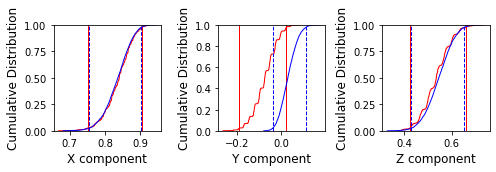

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           1.3
Critical value of V:  6.9
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.0
Critical angle for M&M1990:   13.9
The McFadden and McElhinny (1990) classification for
this test is: 'C'

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


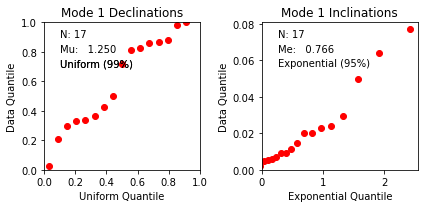

Fisher distribution rejected


result
Bootstrap reversal test                                                             Pass
Parametric reversal test  Pass (angle 6.0º below 13.9º critical angle); C classification
Bayesian reversal test                                     Common mean: positive support
Fisher Q-Q test                                             Fisher distribution rejected

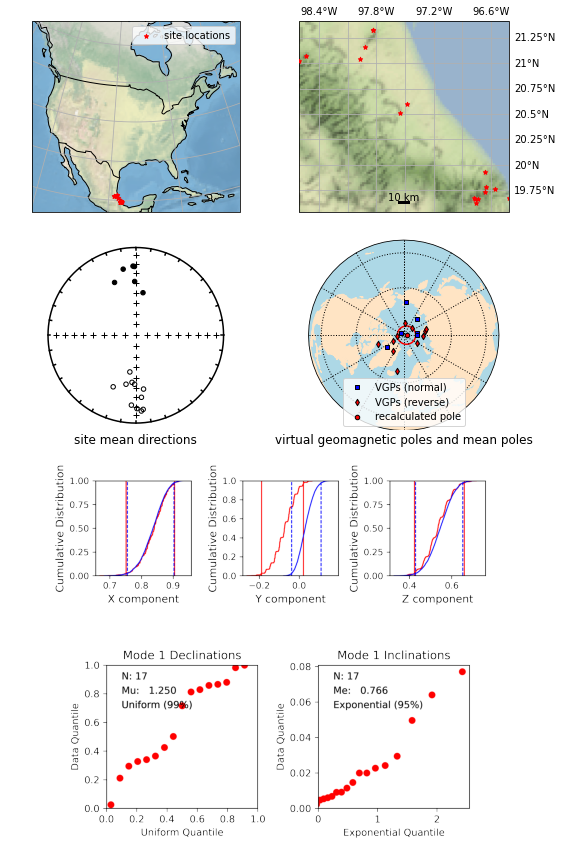


========================= NEW POLE : SW_USA_composite (3) =======================
 => Missing reported VGPs from sites ('name'): ['1C138*']

 => Coherent dec/inc in sites ('name'): ['1C614', '1C651', '1C671', '1C684', '1C701', '2C551', '2C801*', '2C804', '3V021', '3V028', '3V038', '3V048', '3V061', '3V077', '1C118', '2C809', '2C821', '2D005', '2D041*', '2D045', '2D051*', '2D056*', '2D066*', '2D072', '3D101', '3D115', '3D131', '3D138', '3V069', '3X209', '3X245', '3X901*', '3X906', '3X914', '3X921', '4D122', '1C601', '2C516*', '2C576', '2C582', '2C591', '2D001*', '3D107', '3V101', '3V121', '3V148', '3X020', '3X031', '3X038', '4D082', '4D090', '4D183', '4D191', '9E224', '3V001', '3V012*', '3V085', '3V093', '3V109', '3V167', '3X001', '3X013', '4D174', '5G102*', '5G113*', '5G122*', '5G133', '1C143*', '1C151', '1C160*', '2C508*', '2D010*', '2D018*', '2D025*', '2D031*', '2D036*', '3V129*', '3V138*', '3V156', '3V176', '3X216', '3X252*', '3X259', '4D098', '4D106', '4D114', '4D130', '4D140', '4

N  Plat   Plon  A95
Reported mean pole                                  70  87.4  162.9  3.9
Mean pole (calculated from VGPs)                    70  87.4  162.9  3.9
Mean pole (calculated from transformed directions)  70  87.4  163.0  3.9

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


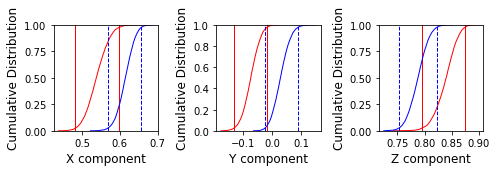

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           9.6
Critical value of V:  6.0
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 7.9
Critical angle for M&M1990:   6.3


Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Ambiguous: weak support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


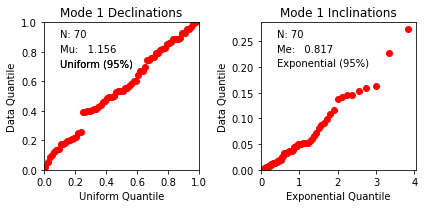

Consistent with Fisher distribution


result
Bootstrap reversal test                                          Pass
Parametric reversal test  Fail (angle 7.9º above 6.3º critical angle)
Bayesian reversal test                        Ambiguous: weak support
Fisher Q-Q test                   Consistent with Fisher distribution

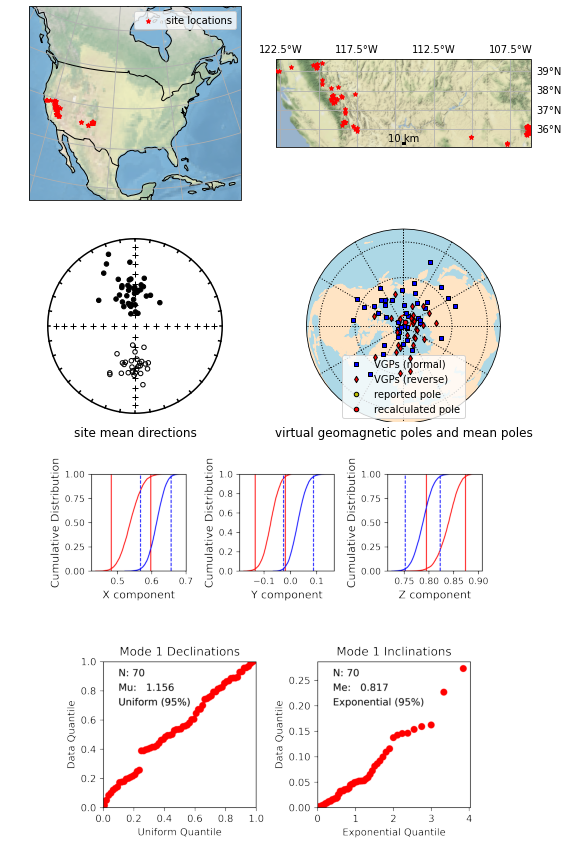


========================= NEW POLE : N_Montana_intrusions (4) =======================
 => Missing reported VGPs from sites ('name'): ['BP10*', 'BP24*', 'BP43*', 'BP16*', 'BP26*', 'BP29*', 'HW6*', 'HW14*', 'HW15*', 'HW35*', 'HW37*', 'EB8*', 'SH5*', 'SH8*', 'SH9*', 'MB-2', 'MB-3', 'MB-4', 'MB-8*', 'MB-9', 'LB9*']

 => inverted vgp from sites ('name'): ['BP4R', 'BP13', 'BP14', 'BP36', 'BP37', 'BP38', 'BP41', 'BP42', 'BP46', 'BP1', 'BP2', 'BP18', 'BP19*', 'BP20', 'BP21', 'BP27*', 'BP28*', 'BP31*', 'BP32', 'BP33', 'BP35*', 'SH1', 'SH2-4', 'SH3', 'SH6', 'SH7', 'SH10', 'SH12', 'SH13', 'SH14', 'MB-5*', 'MB-10', 'LB1', 'LB2', 'LB5', 'LB7*', 'LB8', 'LB10']

 => Coherent dec/inc in sites ('name'): ['BP4N', 'BP6', 'BP7', 'BP9', 'BP12', 'BP23', 'BP34', 'BP39*', 'BP40*', 'BP44', 'BP45', 'BP3', 'BPS', 'BP8*', 'BP15', 'BP17', 'BP11', 'BP25*', 'BP30', 'HW1', 'HW2', 'HW5*', 'HW7', 'HW8', 'HW9', 'HW10', 'HW11', 'HW12', 'HW13', 'HW16', 'HW17', 'HW18', 'HW19', 'HW20*', 'HW21', 'HW22', 'HW23', 'HW24-25-42'

N  Plat   Plon  A95
Reported mean pole                                  94  82.0  170.2  3.5
Mean pole (calculated from VGPs)                    95  82.4  178.4  3.6
Mean pole (calculated from transformed directions)  95  82.3  178.5  3.6

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


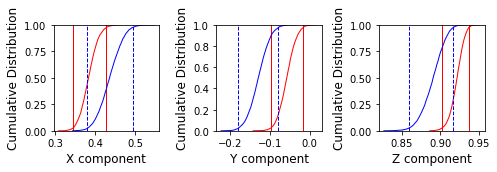

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           6.2
Critical value of V:  6.0
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 5.4
Critical angle for M&M1990:   5.3


Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


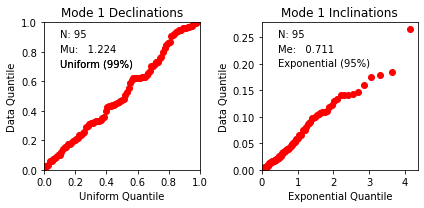

Fisher distribution rejected


result
Bootstrap reversal test                                          Pass
Parametric reversal test  Fail (angle 5.4º above 5.3º critical angle)
Bayesian reversal test                  Common mean: positive support
Fisher Q-Q test                          Fisher distribution rejected

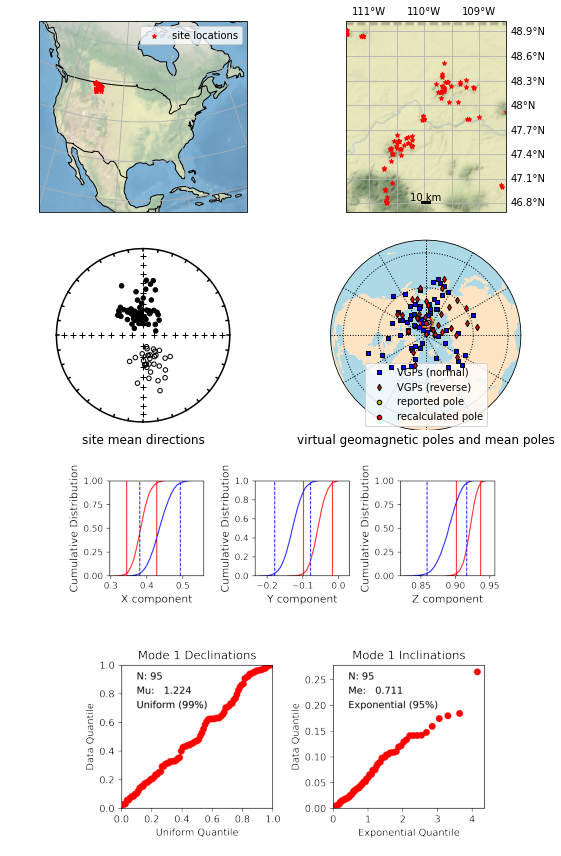


========================= NEW POLE : Long_Valley_Caldera_volcanics (5) =======================
 => Missing reported VGPs from sites ('name'): ['5L326', '5L258', '5L266', '5L274', '5L417', '5L241']

 => Coherent dec/inc in sites ('name'): ['5L209', '5L233', '5L352', '5L452', '5L460', '5L468', '5L344', '5L444', '5L334', '5L385', '5L360', '5L225', '5L201', '5L217', '5L313', '5L321', '5L306', '5L290', '5L282', '5L298', '5L420', '5L565', '5L492', '5L484', '5L401', '5L409', '5L476', '5L368', '5L377', '5L428', '5L393', '5L249', '5L436']

==>Analyzing pole 1 (Long_Valley_Caldera_volcanics).



N  Plat   Plon  A95
Reported mean pole                                  20   NaN    NaN  NaN
Mean pole (calculated from VGPs)                    20  87.7  191.1  7.5
Mean pole (calculated from transformed directions)  20  87.7  191.1  7.5

 
Only one polarity; cannot conduct reversal tests
Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


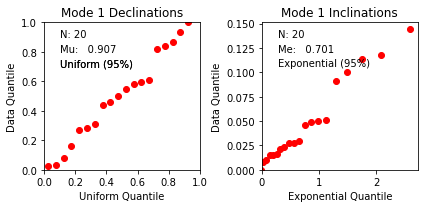

Consistent with Fisher distribution


result
Bootstrap reversal test                     Only one polarity
Parametric reversal test                    Only one polarity
Bayesian reversal test                      Only one polarity
Fisher Q-Q test           Consistent with Fisher distribution

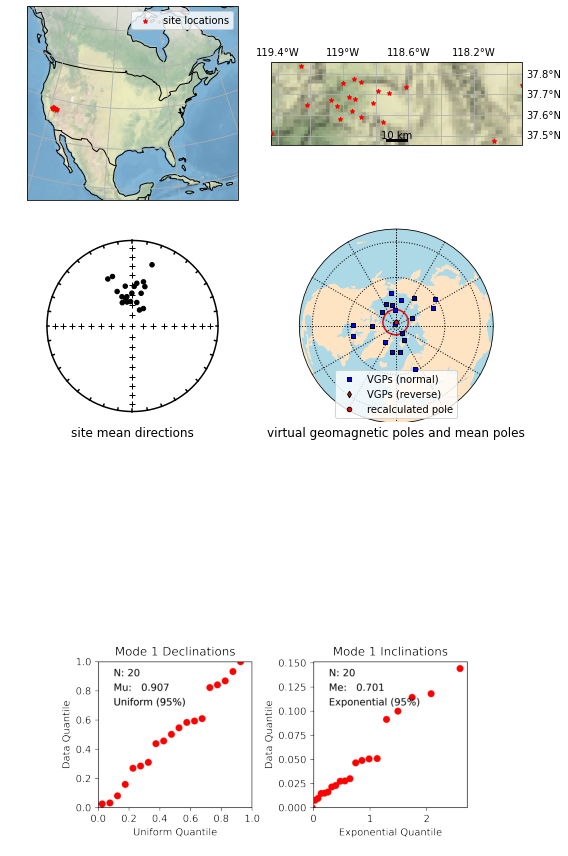


========================= NEW POLE : Robinson_Antincline_intrusions (6) =======================
 => Missing reported VGPs from sites ('name'): [1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]

==>Analyzing pole 1 (Robinson_Antincline_intrusions).



N  Plat   Plon  A95
Reported mean pole                                  16   NaN    NaN  NaN
Mean pole (calculated from VGPs)                    16  77.5  149.8  7.5
Mean pole (calculated from transformed directions)  16  77.5  149.8  7.5

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


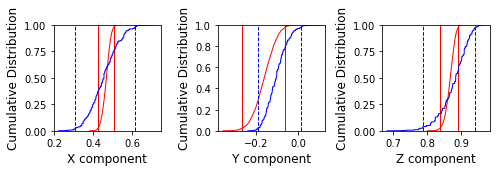

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           0.5
Critical value of V:  7.4
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 3.7
Critical angle for M&M1990:   14.0
The McFadden and McElhinny (1990) classification for
this test is: 'C'

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


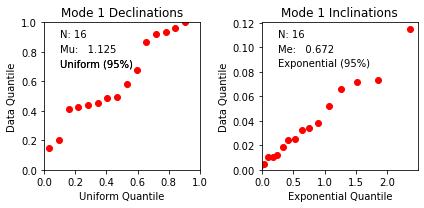

Consistent with Fisher distribution


result
Bootstrap reversal test                                                             Pass
Parametric reversal test  Pass (angle 3.7º below 14.0º critical angle); C classification
Bayesian reversal test                                     Common mean: positive support
Fisher Q-Q test                                      Consistent with Fisher distribution

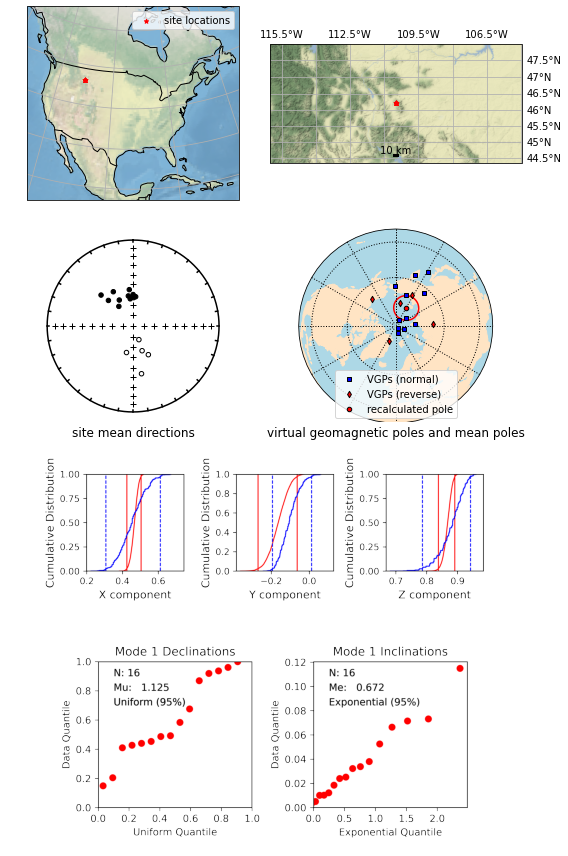


========================= NEW POLE : Central_Mexico_Plio-Pleistocene (7) =======================
 => Coherent dec/inc in sites ('name'): [2.0, 3.0, 4.0, 6.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 17.0, 18.0, 19.0, 20.0]

==>Analyzing pole 1 (Central_Mexico_Plio-Pleistocene).



N  Plat   Plon  A95
Reported mean pole                                  13 -88.8  149.5  5.3
Mean pole (calculated from VGPs)                    13  88.5  331.9  5.3
Mean pole (calculated from transformed directions)  13  88.5  335.0  5.3


Not enough sites from one (or both) polarity populations to conduct Bootstrap and parametric reversal tests

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: very strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


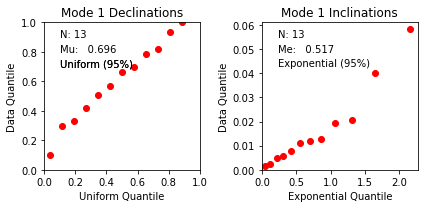

Consistent with Fisher distribution


result
Bootstrap reversal test                 Too few sites for test
Parametric reversal test                Too few sites for test
Bayesian reversal test    Different means: very strong support
Fisher Q-Q test            Consistent with Fisher distribution

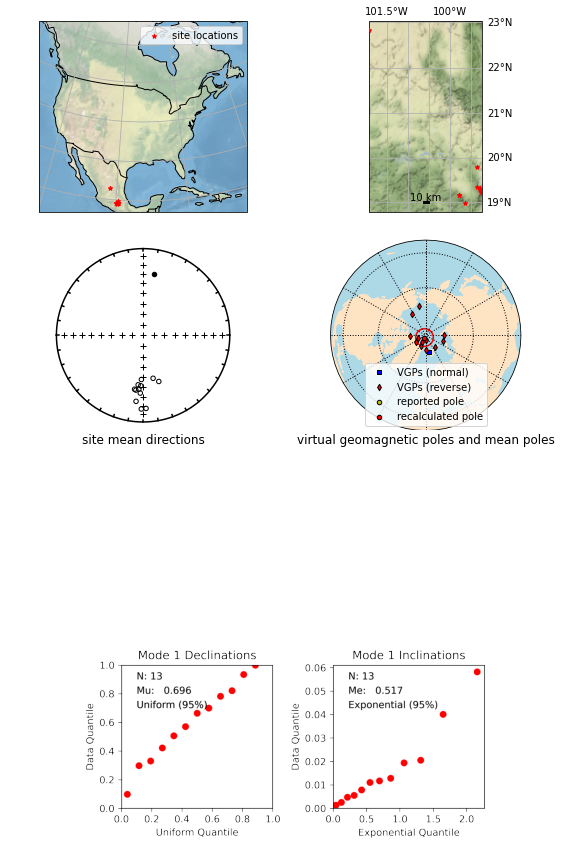


========================= NEW POLE : Rattlesnake_Hills_volcanics (8) =======================
 => inverted vgp from sites ('name'): ['A', 'B', 'C', 'D', 'E', 'F*', 'G', 'H', 'I', 'J', 'K*', 'L', 'M', 'N', 'O*', 'P', 'Q', 'R', 'S', 'T', 'U', 'V*']

==>Analyzing pole 1 (Rattlesnake_Hills_volcanics).



N  Plat   Plon  A95
Reported mean pole                                  18  79.4  146.2  9.6
Mean pole (calculated from VGPs)                    18  79.4  146.1  9.6
Mean pole (calculated from transformed directions)  18  79.4  146.1  9.6

 
Only one polarity; cannot conduct reversal tests
Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


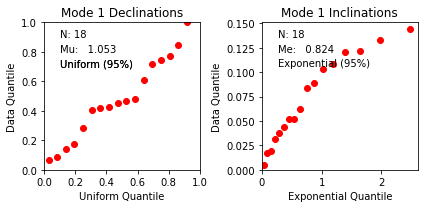

Consistent with Fisher distribution


result
Bootstrap reversal test                     Only one polarity
Parametric reversal test                    Only one polarity
Bayesian reversal test                      Only one polarity
Fisher Q-Q test           Consistent with Fisher distribution

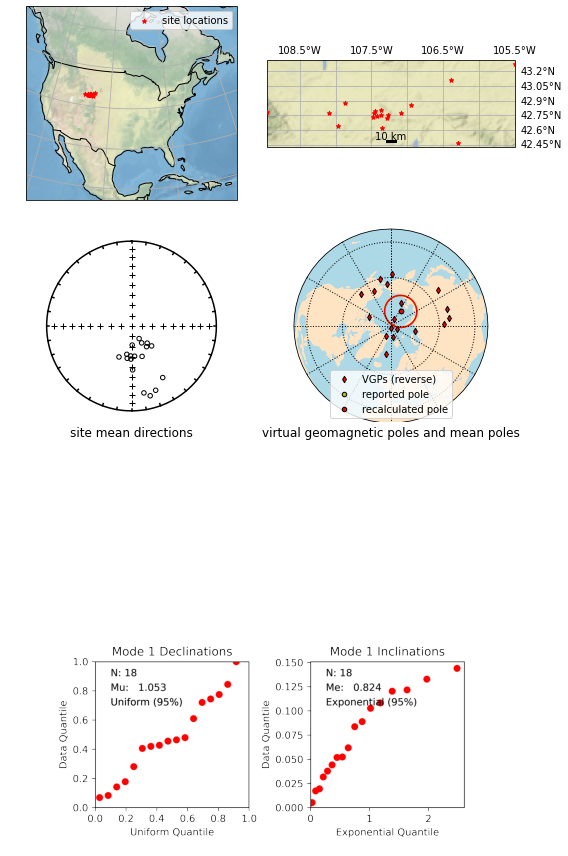


========================= NEW POLE : Ramsay_Island_lavas (9) =======================
 => Missing reported VGPs from sites ('name'): [10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 37.0, 38.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0]

==>Analyzing pole 1 (Ramsay_Island_lavas).



N  Plat   Plon  A95
Reported mean pole                                  11  78.1  119.9  7.0
Mean pole (calculated from VGPs)                    37  83.3  119.2  5.7
Mean pole (calculated from transformed directions)  37  83.3  119.2  5.7


Not enough sites from one (or both) polarity populations to conduct Bootstrap and parametric reversal tests

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: very strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


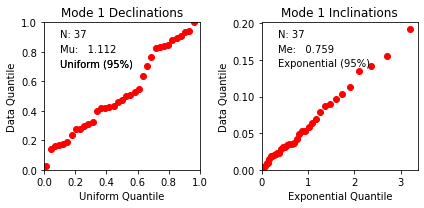

Consistent with Fisher distribution


result
Bootstrap reversal test                 Too few sites for test
Parametric reversal test                Too few sites for test
Bayesian reversal test    Different means: very strong support
Fisher Q-Q test            Consistent with Fisher distribution

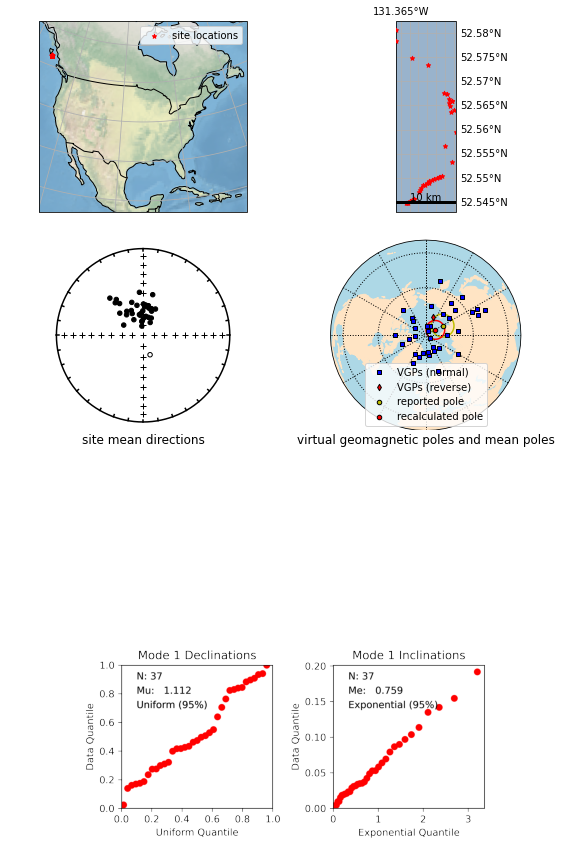


========================= NEW POLE : Sierra_de_Las_Cruces (10) =======================
 => Missing reported VGPs from sites ('name'): ['JQ1', 'JQ2', 'JQ3', 'JQ4', 'CM1*', 'AJ1', 'AJ2', 'IT', 'IT2', 'ST2', 'JI1', 'ST3', 'CR**', 'CR2**', 'PL', 'MT*', 'MT2**', 'ST4', 'ST5', 'ST1', 'AY', 'CH1', 'CH2', 'CH3', 'GU3', 'PC2', 'TO1', 'TO3', 'TO2', 'TO4']

==>Analyzing pole 1 (Sierra_de_Las_Cruces).



N  Plat   Plon  A95
Reported mean pole                                  25  80.1  161.8  4.5
Mean pole (calculated from VGPs)                    25  80.8  156.6  4.7
Mean pole (calculated from transformed directions)  25  80.8  156.6  4.7

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


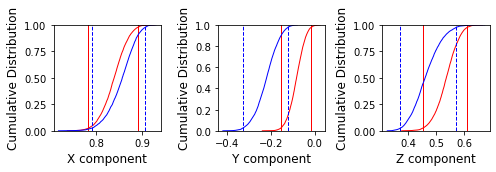

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           4.5
Critical value of V:  6.5
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 9.0
Critical angle for M&M1990:   10.9
The McFadden and McElhinny (1990) classification for
this test is: 'C'

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


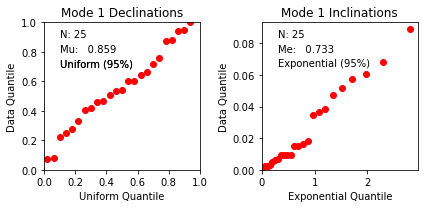

Consistent with Fisher distribution


result
Bootstrap reversal test                                                             Pass
Parametric reversal test  Pass (angle 9.0º below 10.9º critical angle); C classification
Bayesian reversal test                                     Common mean: positive support
Fisher Q-Q test                                      Consistent with Fisher distribution

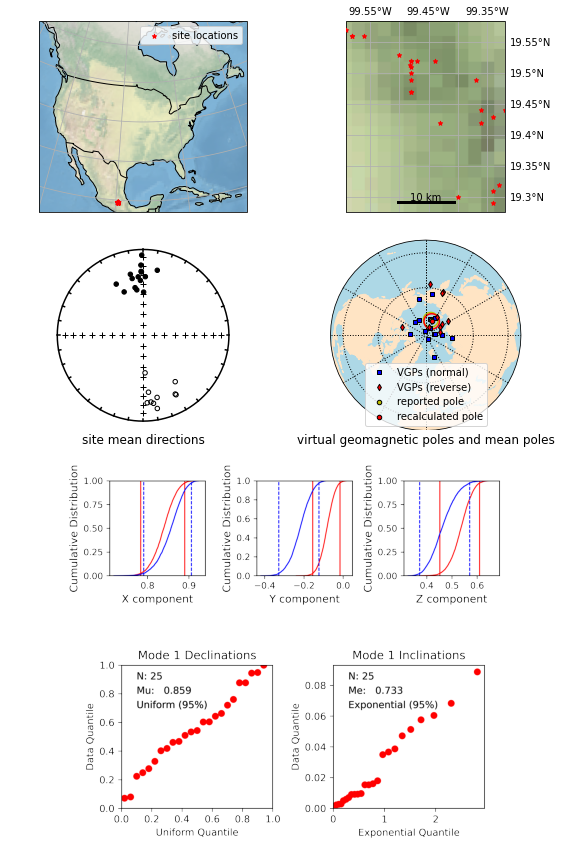


========================= NEW POLE : Snake_River_Plain (11) =======================
 => Coherent dec/inc in sites ('name'): ['sr01', 'sr03', 'sr04', 'sr09', 'sr11', 'sr12', 'sr16', 'sr19', 'sr20', 'sr21', 'sr22', 'sr23', 'sr24', 'sr25', 'sr26', 'sr27', 'sr28', 'sr29', 'sr30', 'sr31', 'sr34', 'sr36', 'sr37', 'sr39', 'sr40', 'sr42']

==>Analyzing pole 1 (Snake_River_Plain).



N  Plat Plon  A95
Reported mean pole                                  23  86.9  7.8  6.2
Mean pole (calculated from VGPs)                    23  86.9  7.8  6.2
Mean pole (calculated from transformed directions)  23  86.9  7.8  6.2

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


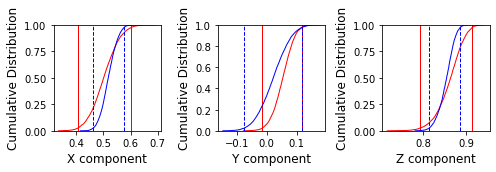

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           0.3
Critical value of V:  6.5
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 2.1
Critical angle for M&M1990:   10.0
The McFadden and McElhinny (1990) classification for
this test is: 'B'

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


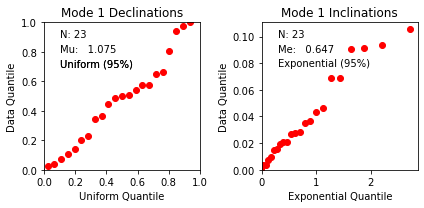

Consistent with Fisher distribution


result
Bootstrap reversal test                                                             Pass
Parametric reversal test  Pass (angle 2.1º below 10.0º critical angle); B classification
Bayesian reversal test                                       Common mean: strong support
Fisher Q-Q test                                      Consistent with Fisher distribution

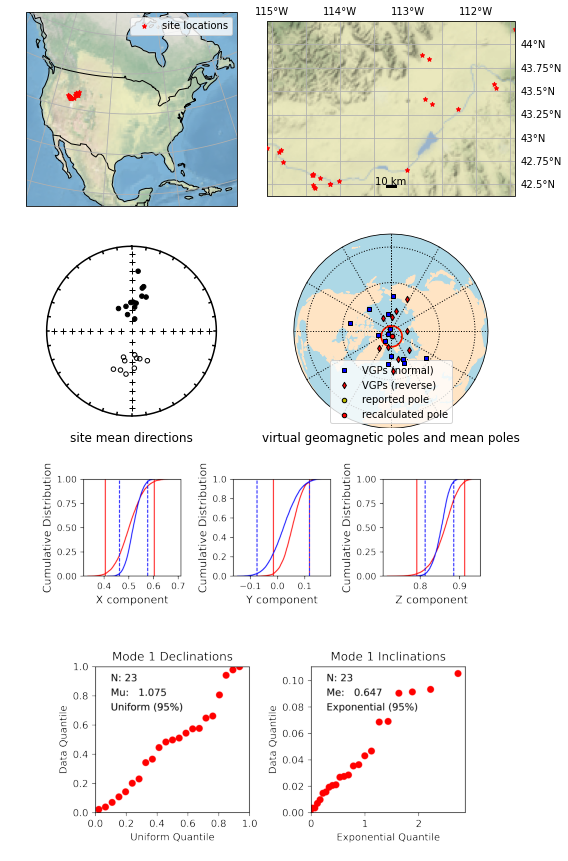


========================= NEW POLE : Sonoma_volcanics (12) =======================
 => Missing reported VGPs from sites ('name'): [8.0, 9.0, 13.0, 17.0, 18.0, 20.0, 22.0, 23.0, 24.0, 26.0, 27.0, 29.0]

 => Coherent dec/inc in sites ('name'): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 11.0, 12.0, 14.0, 15.0, 16.0, 19.0, 21.0, 25.0, 28.0, 30.0, 31.0, 'SV27 (S28)', 'SV26', 'SV25 (S7)', 'SV24 (S6)', 'SV23', 'SV22', 'SV21', 'SV20', 'SV19 (S4, S5)', 'SV18 (S3)', 'SV17 (S2)', 'SV16', 'SV15', 'SV14', 'SV13', 'SV12', 'SV11 (S19)', 'SV10 (S16)', 'SV9', 'SV8 (S15)', 'SV7 (S14)', 'SV6 (S12)', 'SV5 (S11)', 'SV4 (S21)', 'SV3 (S20)', 'SV2', 'SV1']

==>Analyzing pole 1 (Sonoma_volcanics).



N  Plat  Plon  A95
Reported mean pole                                  25  80.2  69.2  6.8
Mean pole (calculated from VGPs)                    26  80.3  68.9  6.5
Mean pole (calculated from transformed directions)  26  80.3  68.8  6.5

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


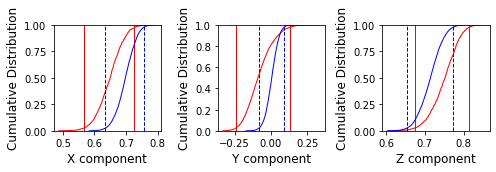

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           1.2
Critical value of V:  7.0
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 6.0
Critical angle for M&M1990:   14.6
The McFadden and McElhinny (1990) classification for
this test is: 'C'

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


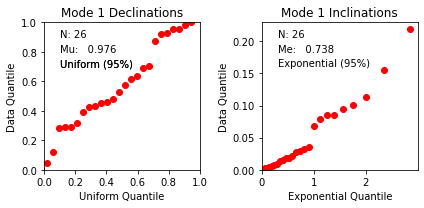

Consistent with Fisher distribution


result
Bootstrap reversal test                                                             Pass
Parametric reversal test  Pass (angle 6.0º below 14.6º critical angle); C classification
Bayesian reversal test                                     Common mean: positive support
Fisher Q-Q test                                      Consistent with Fisher distribution

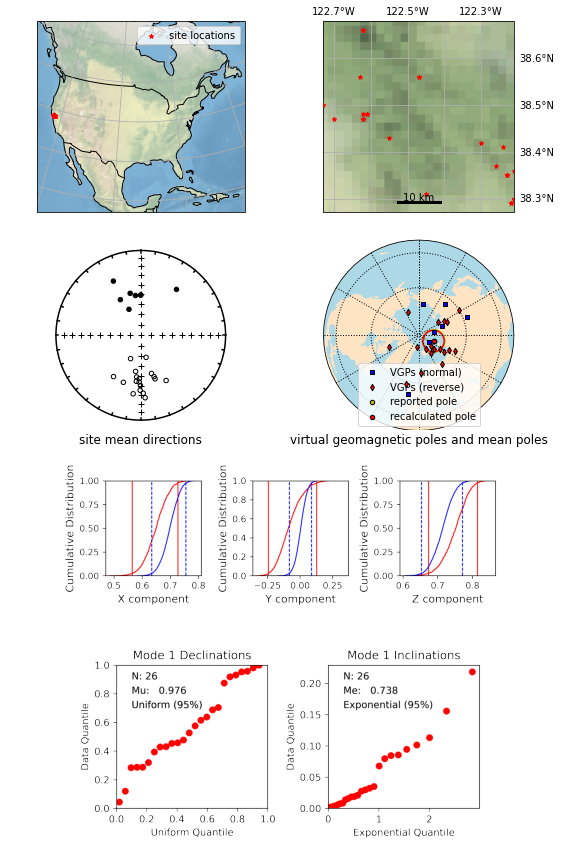


========================= NEW POLE : Mistastin_Lake_impact (13) =======================
 => Missing reported VGPs from sites ('name'): [1.0, 2.0, 3.0, '4_adj', '5_adj', 6.0, '7_adj', 8.0, 9.0, 10.0, 12.0, 1.0, 2.0, 3.0, 4.0, 5.0, 11.0, 10.0, 9.0, 6.0, '6-ani', 7.0, '7-ani', 13.0, 14.0, 15.0, 17.0]

==>Analyzing pole 1 (Mistastin_Lake_impact).



N  Plat   Plon  A95
Reported mean pole                                  10  85.5  117.7  NaN
Mean pole (calculated from VGPs)                    10  85.5  121.0  4.4
Mean pole (calculated from transformed directions)  10  85.5  121.0  4.4

 
Only one polarity; cannot conduct reversal tests
Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------
Not enough sites to conduct Q-Q test


result
Bootstrap reversal test   Only one polarity
Parametric reversal test  Only one polarity
Bayesian reversal test    Only one polarity
Fisher Q-Q test               Too few sites

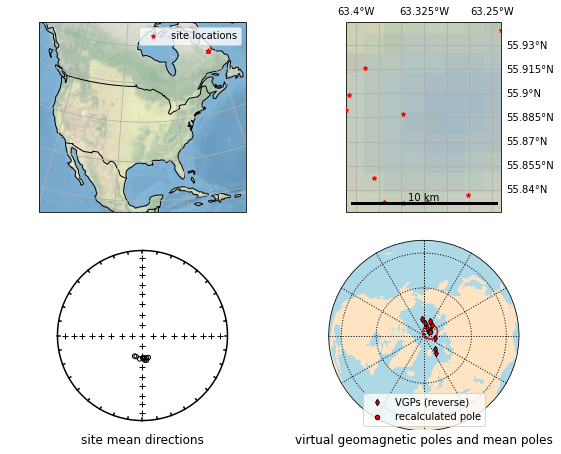

==>Analyzing pole 2 (Mistastin_Lake_impact).



N  Plat  Plon  A95
Reported mean pole                                  15   NaN   NaN  NaN
Mean pole (calculated from VGPs)                    15  83.7  99.9  4.1
Mean pole (calculated from transformed directions)  15  83.7  99.9  4.1

 
Only one polarity; cannot conduct reversal tests
Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


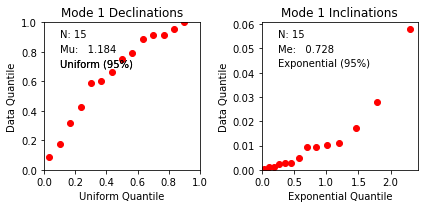

Consistent with Fisher distribution


result
Bootstrap reversal test                     Only one polarity
Parametric reversal test                    Only one polarity
Bayesian reversal test                      Only one polarity
Fisher Q-Q test           Consistent with Fisher distribution

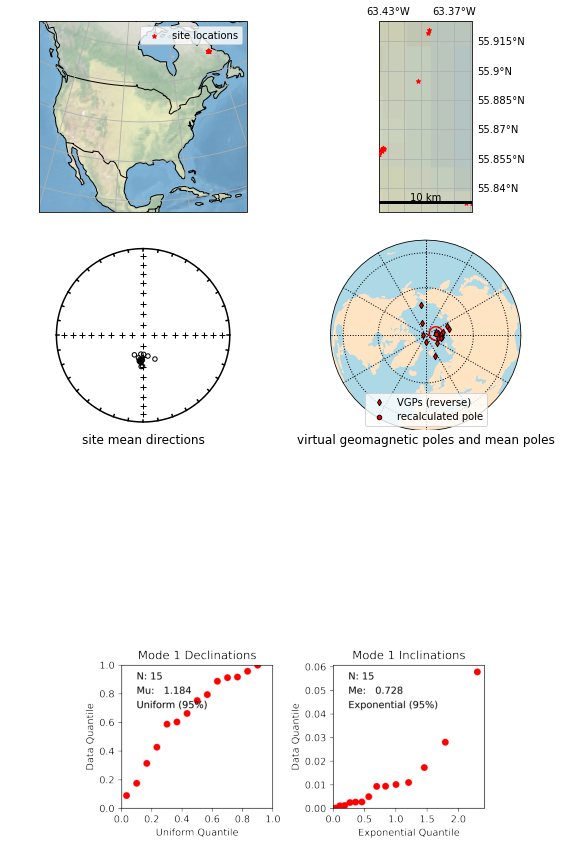


========================= NEW POLE : Bighorn_Basin_sediments (14) =======================
 => Coherent dec/inc in sites ('name'): ['BH0414β', 'BH0401α', 'BH0403α', 'BH0404α', 'BH0405α', 'BH0407α', 'BH0408α', 'BH0410α', 'BH0412β', 'BH02015α', 'BH02016β', 'BH02019β', 'BH02018β', 'BH02020β', 'BH02021β', 'BH0415α', 'BH0416α', 'BH0417α', 'BH0418β', 'BH0419α', 'BH0420α', 'BH0421α', 'BH0422α', 'BH02034α', 'BH02035α', 'BH02037α', 'BH02038α', 'BH02039α', 'BH02040α', 'BH02041α', 'BH02042α', 'BH02043α', 'BH02044α', 'BH0423α', 'BH0424α', 'BH0425α', 'BH0426a', 'BH0427β', 'BH0433β', 'BH01025α', 'BH01027α', 'BH01028α', 'BH01031α', 'BH01033β', 'BH01036β', 'BH01037β', 'BH01038α', 'BH01039α', 'BH01040α', 'BH01041β', 'BH01042β', 'BH01043α', 'BH01045α', 'BH01046α', 'BH01049α', 'BH01050α', 'BH01051α', 'BH01052β', 'BH01053α', 'BH01054β', 'BH01055α', 'BH01056β', 'BH01057β', 'BH01061β', 'BH01064α', 'BH01066β', 'BH01068β', 'BH01071β', 'BH01073α', 'BH01075β', 'BH01076α', 'BH01077α', 'BH01079β', 'BH01080α', 'BH

N  Plat   Plon  A95
Reported mean pole                                  59   NaN    NaN  NaN
Mean pole (calculated from VGPs)                    59  81.6  182.8  6.0
Mean pole (calculated from transformed directions)  59  81.5  182.8  6.0

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


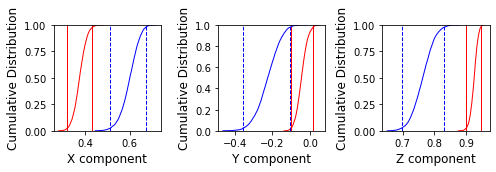

Fail, distinct in x, y and z

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           24.4
Critical value of V:  6.4
"Fail": Since V is greater than Vcrit, the two means can
be distinguished at the 95% confidence level.

M&M1990 classification:

Angle between data set means: 19.2
Critical angle for M&M1990:   9.8


Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: very strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


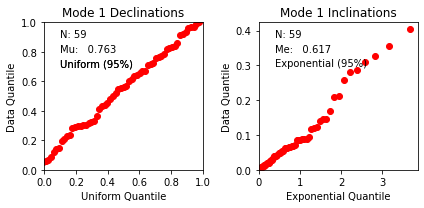

Consistent with Fisher distribution


result
Bootstrap reversal test                                           Fail
Parametric reversal test  Fail (angle 19.2º above 9.8º critical angle)
Bayesian reversal test            Different means: very strong support
Fisher Q-Q test                    Consistent with Fisher distribution

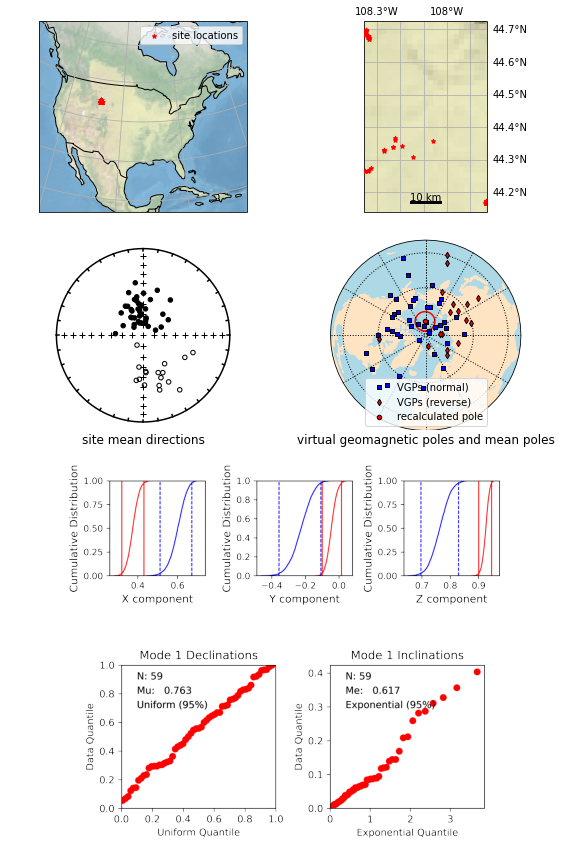


========================= NEW POLE : Absaroka_volcanics (15) =======================
 => Missing reported VGPs from sites ('name'): [10.0, 'Lower Flow mean', 'Middle Flow mean', 'Upper Flow mean', 620.0, 622.0, 617.0, '617+624+625 mean', 'I8']

 => inverted vgp from sites ('name'): ['7*', 8.0, '35*', '4b', '4a', 4.0, '5b', '5a', 5.0, 44.0, '43*', '3b', '3a', 3.0, '2b', '2a', '2*', '16b', '16a', 16.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 389.0, 390.0, '389+390 mean', 394.0, 396.0, 624.0, 625.0, 'I1', 'I2', 'I3', 'I4', 'I6', 'I7', 'Independence stock mean', 'I5']

 => Coherent dec/inc in sites ('name'): [6.0, '33*', '34*', '36*', '37*', '38*', 39.0, 40.0, '41*', 51.0, '50*', '49*', 48.0, '47*', 31.0, 32.0, 14.0, '13*', 

N  Plat   Plon   A95
Reported mean pole                                  19  83.5  177.4  10.1
Mean pole (calculated from VGPs)                    19  83.4  178.6  11.1
Mean pole (calculated from transformed directions)  19  83.4  178.6  11.1

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


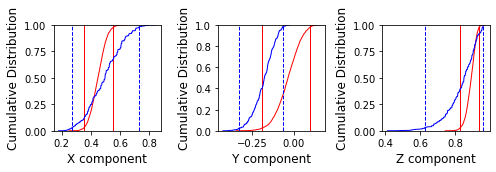

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           1.1
Critical value of V:  7.1
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 9.0
Critical angle for M&M1990:   22.6
The McFadden and McElhinny (1990) classification for
this test is: 'INDETERMINATE;

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


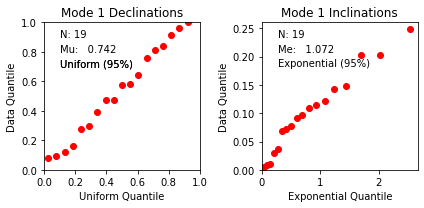

Consistent with Fisher distribution


result
Bootstrap reversal test                                                                         Pass
Parametric reversal test  Pass (angle 9.0º below 22.6º critical angle); indeterminate classification
Bayesian reversal test                                                 Common mean: positive support
Fisher Q-Q test                                                  Consistent with Fisher distribution

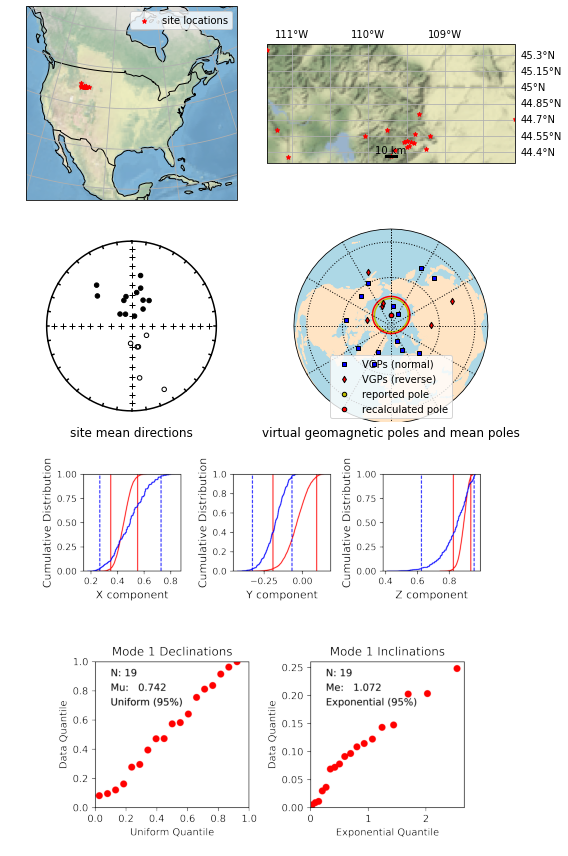

==>Analyzing pole 2 (Absaroka_volcanics).



N  Plat  Plon   A95
Reported mean pole                                  3   NaN   NaN   NaN
Mean pole (calculated from VGPs)                    3  65.6  94.6  58.4
Mean pole (calculated from transformed directions)  3  65.6  94.6  58.4


Not enough sites from one (or both) polarity populations to conduct Bootstrap and parametric reversal tests

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: very strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------
Not enough sites to conduct Q-Q test


result
Bootstrap reversal test                 Too few sites for test
Parametric reversal test                Too few sites for test
Bayesian reversal test    Different means: very strong support
Fisher Q-Q test                                  Too few sites

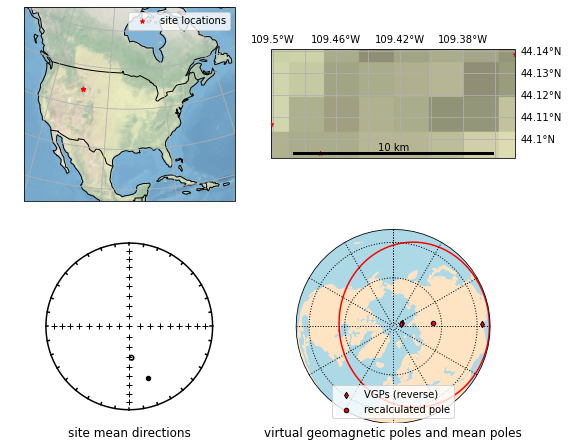

==>Analyzing pole 3 (Absaroka_volcanics).



N  Plat   Plon  A95
Reported mean pole                                  22  80.8  145.9  8.6
Mean pole (calculated from VGPs)                    22  80.8  146.7  8.6
Mean pole (calculated from transformed directions)  22  80.8  146.6  8.6

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


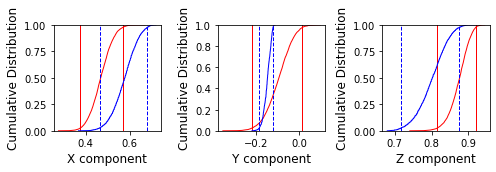

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           2.9
Critical value of V:  6.7
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 8.0
Critical angle for M&M1990:   12.2
The McFadden and McElhinny (1990) classification for
this test is: 'C'

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


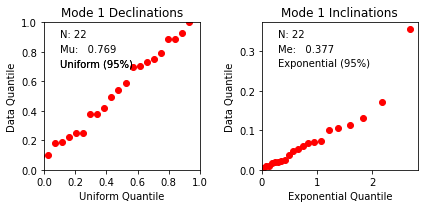

Consistent with Fisher distribution


result
Bootstrap reversal test                                                             Pass
Parametric reversal test  Pass (angle 8.0º below 12.2º critical angle); C classification
Bayesian reversal test                                     Common mean: positive support
Fisher Q-Q test                                      Consistent with Fisher distribution

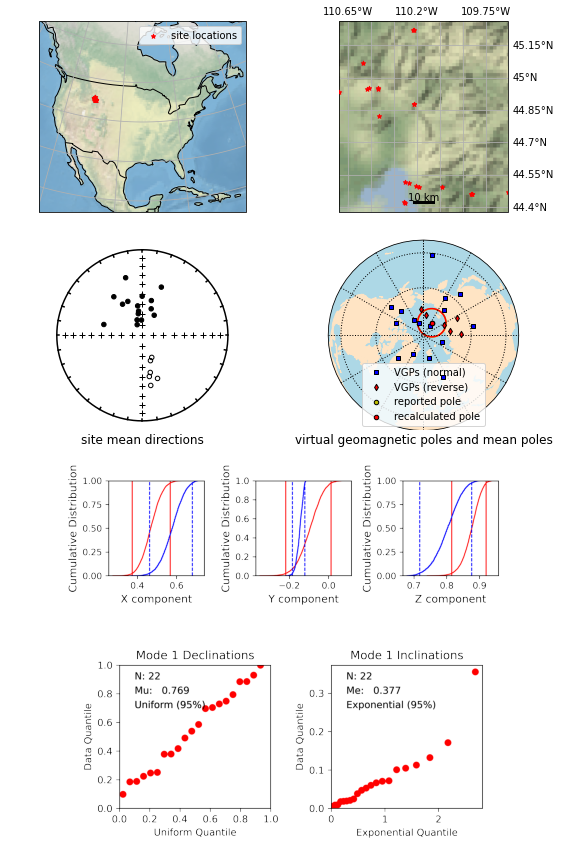


========================= NEW POLE : Eastern_TMVB (16) =======================
 => Missing reported VGPs from sites ('name'): ['SM1', 'SM2*', 'SM3', 'SM4', 'SM5', 'SM6*', 'SM7', 'SM8', 'SM9*', 'SM10*', 'SM11', 'SM12*', 'SM13', 'SM14', 'SM15', 'SM16', 'SM17', 'PS2 (VE34)', 'PS3* (VE71b)', 'PS4 (VE15)', 'PS1 (VE108)', 'CA2', 'MC2', 'MM1', 'XO1 (VE118)', 'CY1 (VE118)', 'MI1 (VE118)', 'MR1* (VE118)', 'JA1 (PH113)', 'TRT (TH24)', 'MO1 (PH171)', 'MZ1 (PH135)', 'ZC1 (PH141)', 'MS2-3 (VE94)', 'ZC2', 'SB1', 'ZC3', 'PL1 (PH62)', 'AT1 (PH40)']

==>Analyzing pole 1 (Eastern_TMVB).



N  Plat   Plon  A95
Reported mean pole                                  12  86.8   96.8  6.5
Mean pole (calculated from VGPs)                    12  86.3  116.9  6.8
Mean pole (calculated from transformed directions)  12  86.3  116.9  6.8


Not enough sites from one (or both) polarity populations to conduct Bootstrap and parametric reversal tests

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: very strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


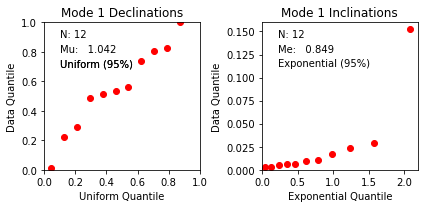

Consistent with Fisher distribution


result
Bootstrap reversal test                 Too few sites for test
Parametric reversal test                Too few sites for test
Bayesian reversal test    Different means: very strong support
Fisher Q-Q test            Consistent with Fisher distribution

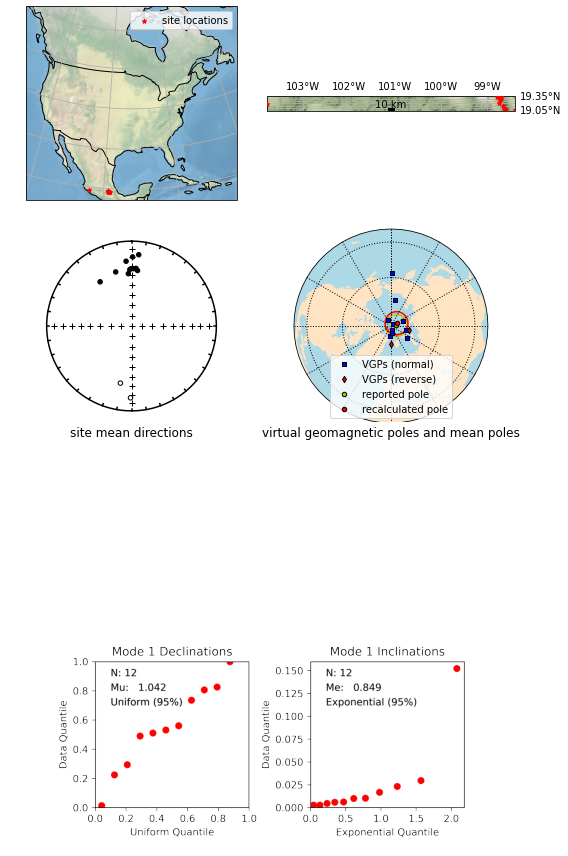

==>Analyzing pole 2 (Eastern_TMVB).



N  Plat   Plon   A95
Reported mean pole                                  3  82.1  190.7  18.0
Mean pole (calculated from VGPs)                    3  82.5  180.8  14.3
Mean pole (calculated from transformed directions)  3  82.5  180.8  14.3


Not enough sites from one (or both) polarity populations to conduct Bootstrap and parametric reversal tests

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Different means: very strong support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------
Not enough sites to conduct Q-Q test


result
Bootstrap reversal test                 Too few sites for test
Parametric reversal test                Too few sites for test
Bayesian reversal test    Different means: very strong support
Fisher Q-Q test                                  Too few sites

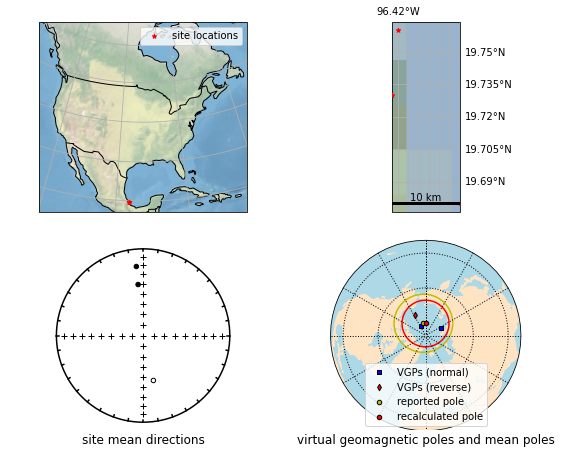

==>Analyzing pole 3 (Eastern_TMVB).



N  Plat   Plon  A95
Reported mean pole                                  17  80.5  188.1  8.1
Mean pole (calculated from VGPs)                    17  79.8  186.2  8.5
Mean pole (calculated from transformed directions)  17  79.8  186.2  8.5

Bootstrap reversal test (Tauxe et al., 1991)
------------------------------------------------


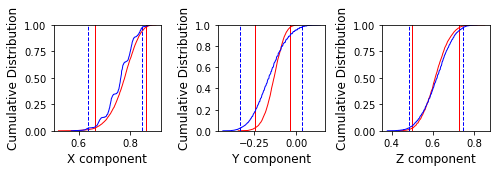

Pass

Parametric reversal test with classification (McFadden and McElhinny, 1990)
------------------------------------------------
Results of Watson V test: 

Watson's V:           0.1
Critical value of V:  6.7
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 1.7
Critical angle for M&M1990:   18.0
The McFadden and McElhinny (1990) classification for
this test is: 'C'

Bayesian reversal test (Heslop & Roberts, 2018)
------------------------------------------------
Common mean: positive support

Fisher distribution Q-Q test (Fisher et al., 1987)
------------------------------------------------


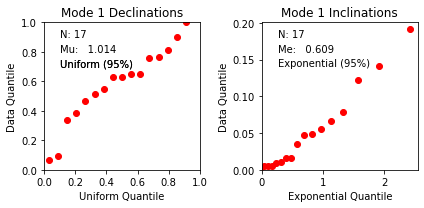

Consistent with Fisher distribution


result
Bootstrap reversal test                                                             Pass
Parametric reversal test  Pass (angle 1.7º below 18.0º critical angle); C classification
Bayesian reversal test                                     Common mean: positive support
Fisher Q-Q test                                      Consistent with Fisher distribution

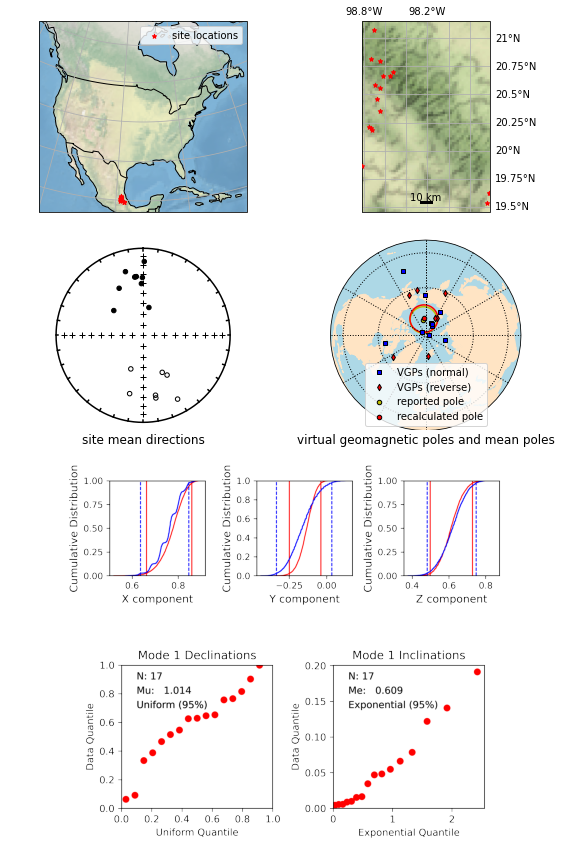


========================= NEW POLE : Bishop_tuff (17) =======================
 => Missing reported VGPs from sites ('name'): ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B17', 'B18', 'B19', 'B20', 'B21', 'B23', 'B24', 'B25 (0 m)', 'B25 (3 m)', 'B25 (6 m)', 'B25 (9 m)', 'B25 (12 m)', 'B25 (15 m)', 'B25 (18 m)', 'B25 (21 m)', 'B25 (24 m)', 'B25 (27 m)', 'B25 (30 m)', 'B25 (33 m)', 'B26', 'B27', 'C001', 'C041', 'C051', 'C071', 'C615', 'C621', 'C530', 'C538', 'Xen', 'LT', 'Bishop Tuff mean']

==>Analyzing pole 1 (Bishop_tuff).



KeyError: 'alpha95'

In [15]:
studies, pps, misfit, misfit_type = [], [], [], []

for file_idx in range(0,len(df_files)+1):
    print(f'')
    print(f'========================= NEW POLE : {df_files.name_xlsx[file_idx]} ({file_idx}) =======================')
    
    df_poles, df_vgps = split_datasheet(df_files, file_idx)
    df_vgps = recalc_vgps(df_vgps)
    df_vgps = check_coherence_vgps(df_vgps)
    verbose(df_vgps)
    process_study(df_vgps,file_idx)   